In [5]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
import pickle
import seaborn as sns
import datetime as dt
import yfinance as yf
import talib
from tqdm.notebook import tqdm
%matplotlib inline









class LinearModel:
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)
        self.vW = 0
        self.vb = 0
        self.losses = []

    def predict(self, s):
        return s.dot(self.W) + self.b

    def sgd(self, s, Y, learning_rate=0.001, momentum=0.9):
        num_values = np.prod(Y.shape)
        Y_hat = self.predict(s)
        Y_hat = self.predict(s)  # shape (1, 8)
        gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
        gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

        self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
        self.vb = momentum * self.vb - learning_rate * gb  # scalar

        self.W += self.vW  # vector shape (7, 8)
        self.b += self.vb  # scalar

        mse = np.mean((Y_hat - Y) ** 2)
        self.losses.append(mse)

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']


class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


class StockEnv:
    def __init__(self, data, capital, high,trade_fee_bid_percent=0.01, trade_fee_ask_percent=0.005):
        self.trade_fee_bid_percent = trade_fee_bid_percent / 100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent / 100  # percent

        self.stock_price_history = data['Adj Close']
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 5  # [stock price, stock_owned, cash__in_hand, rsi, mom]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0, 1]
        self.sell_buy = []
        self.save_stock_price = []
        self.rsi = data['rsi']
        self.mom = data['mom']
        self.cashflow = None
        self.high = high
        self.reset()

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi[self.current_step]
        vector[4] = self.mom[self.current_step]
        return vector

    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history[self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        self.cashflow = [0]
        return self.state_vector()

    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    

    def cal_position(self):
        mid_price = self.high / 2
        max_pos = self.capital / mid_price
        slope = max_pos / -self.high
        c = -slope * self.high

        return slope * self.stock_price + c, max_pos
    

    def trade(self, action):
        '''
        action 0 = hold
        action 1 = take action
        '''
        assert action in self.action_space

        if action == 1:
            position_sh, max_pos = self.cal_position()
            diff = position_sh - self.stock_owned
            if diff < 0:
                # sell
                self.stock_owned = position_sh
                self.cash_in_hand += (abs(diff) * self.stock_price * (1 - self.trade_fee_ask_percent))  
                
                cash_flow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                                    .5 * (max_pos + self.stock_owned) * self.stock_price)
                
                self.cash_in_hand -= cash_flow
                self.cashflow.append(cash_flow)
                self.sell_buy.append('sell')


            elif diff > 0:
                # buy
                self.stock_owned = position_sh
                self.cash_in_hand -= (abs(diff) * self.stock_price * (1 + self.trade_fee_bid_percent))
                
                cash_flow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                            .5 * (max_pos + self.stock_owned) * self.stock_price)
                
                self.cash_in_hand -= cash_flow
                self.cashflow.append(cash_flow)
                self.sell_buy.append('buy')

            else:
                self.cashflow.append(0)
                self.sell_buy.append('hold')

        else:
            self.cashflow.append(0)
            self.sell_buy.append('hold')

        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)

    def step(self, action):
        assert action in self.action_space

        prev_val = sum(self.cashflow)
        self.current_step += 1
        self.stock_price = self.stock_price_history[self.current_step]

        self.trade(action)
        current_val = sum(self.cashflow)
        reward = current_val - prev_val
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                #                 'current_val': self.port_val(),
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                'cashflow':self.cashflow
                }

        return self.state_vector(), reward, done, info


def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


def play_one_episode(agent, env, is_train, scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])

        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)

        state = next_state

    return info

In [6]:
stock_name = 'ibm'.upper()
stock_data = pd.read_csv(f'../train_test_data/{stock_name}.csv', index_col=['Date'], parse_dates=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]

high = stock_data['Adj Close'].max()


num_episodes = 2000
batch_size = 32
capital = 1000
data = stock_data['Adj Close'].values
n_timesteps = data.shape[0]


env = StockEnv(train_data, capital, high)
state_size = env.state_dim
action_size = 2
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

  0%|          | 0/2000 [00:00<?, ?it/s]

episode: 1/2000, episode end value: 108.39, duration: 0:00:00.380098
episode: 2/2000, episode end value: 103.27, duration: 0:00:00.311068
episode: 3/2000, episode end value: 105.28, duration: 0:00:00.300055
episode: 4/2000, episode end value: 105.55, duration: 0:00:00.302073
episode: 5/2000, episode end value: 104.95, duration: 0:00:00.292070
episode: 6/2000, episode end value: 105.22, duration: 0:00:00.301068
episode: 7/2000, episode end value: 105.20, duration: 0:00:00.296066
episode: 8/2000, episode end value: 104.72, duration: 0:00:00.301067
episode: 9/2000, episode end value: 104.73, duration: 0:00:00.304052
episode: 10/2000, episode end value: 104.67, duration: 0:00:00.300072
episode: 11/2000, episode end value: 105.16, duration: 0:00:00.300078
episode: 12/2000, episode end value: 104.61, duration: 0:00:00.300051
episode: 13/2000, episode end value: 105.06, duration: 0:00:00.298080
episode: 14/2000, episode end value: 105.60, duration: 0:00:00.301078
episode: 15/2000, episode end

episode: 119/2000, episode end value: 102.22, duration: 0:00:00.309067
episode: 120/2000, episode end value: 101.20, duration: 0:00:00.317069
episode: 121/2000, episode end value: 103.11, duration: 0:00:00.313069
episode: 122/2000, episode end value: 103.55, duration: 0:00:00.307068
episode: 123/2000, episode end value: 104.68, duration: 0:00:00.316071
episode: 124/2000, episode end value: 103.17, duration: 0:00:00.323057
episode: 125/2000, episode end value: 102.41, duration: 0:00:00.324088
episode: 126/2000, episode end value: 95.13, duration: 0:00:00.348078
episode: 127/2000, episode end value: 104.21, duration: 0:00:00.322072
episode: 128/2000, episode end value: 104.44, duration: 0:00:00.322072
episode: 129/2000, episode end value: 103.93, duration: 0:00:00.328073
episode: 130/2000, episode end value: 100.83, duration: 0:00:00.327072
episode: 131/2000, episode end value: 101.24, duration: 0:00:00.321070
episode: 132/2000, episode end value: 101.49, duration: 0:00:00.324072
episode

episode: 238/2000, episode end value: 99.79, duration: 0:00:00.330073
episode: 239/2000, episode end value: 98.84, duration: 0:00:00.347077
episode: 240/2000, episode end value: 93.88, duration: 0:00:00.350078
episode: 241/2000, episode end value: 99.90, duration: 0:00:00.338076
episode: 242/2000, episode end value: 101.34, duration: 0:00:00.330073
episode: 243/2000, episode end value: 104.77, duration: 0:00:00.328084
episode: 244/2000, episode end value: 101.14, duration: 0:00:00.324071
episode: 245/2000, episode end value: 101.03, duration: 0:00:00.330074
episode: 246/2000, episode end value: 96.53, duration: 0:00:00.357080
episode: 247/2000, episode end value: 100.07, duration: 0:00:00.333073
episode: 248/2000, episode end value: 111.42, duration: 0:00:00.360079
episode: 249/2000, episode end value: 78.75, duration: 0:00:00.413078
episode: 250/2000, episode end value: 97.49, duration: 0:00:00.338089
episode: 251/2000, episode end value: 81.77, duration: 0:00:00.353078
episode: 252/2

episode: 357/2000, episode end value: 97.71, duration: 0:00:00.343075
episode: 358/2000, episode end value: 98.40, duration: 0:00:00.335061
episode: 359/2000, episode end value: 96.47, duration: 0:00:00.347091
episode: 360/2000, episode end value: 100.92, duration: 0:00:00.331073
episode: 361/2000, episode end value: 100.40, duration: 0:00:00.339087
episode: 362/2000, episode end value: 103.98, duration: 0:00:00.318071
episode: 363/2000, episode end value: 101.56, duration: 0:00:00.326072
episode: 364/2000, episode end value: 108.87, duration: 0:00:00.330073
episode: 365/2000, episode end value: 103.50, duration: 0:00:00.325073
episode: 366/2000, episode end value: 103.06, duration: 0:00:00.327074
episode: 367/2000, episode end value: 100.63, duration: 0:00:00.337074
episode: 368/2000, episode end value: 106.56, duration: 0:00:00.332074
episode: 369/2000, episode end value: 102.35, duration: 0:00:00.334073
episode: 370/2000, episode end value: 92.78, duration: 0:00:00.381084
episode: 3

episode: 475/2000, episode end value: 98.65, duration: 0:00:00.346087
episode: 476/2000, episode end value: 96.88, duration: 0:00:00.342076
episode: 477/2000, episode end value: 102.12, duration: 0:00:00.323072
episode: 478/2000, episode end value: 98.64, duration: 0:00:00.339076
episode: 479/2000, episode end value: 103.15, duration: 0:00:00.326072
episode: 480/2000, episode end value: 101.21, duration: 0:00:00.325073
episode: 481/2000, episode end value: 104.24, duration: 0:00:00.342075
episode: 482/2000, episode end value: 104.53, duration: 0:00:00.325073
episode: 483/2000, episode end value: 101.48, duration: 0:00:00.330073
episode: 484/2000, episode end value: 99.44, duration: 0:00:00.344076
episode: 485/2000, episode end value: 102.65, duration: 0:00:00.324073
episode: 486/2000, episode end value: 107.85, duration: 0:00:00.322071
episode: 487/2000, episode end value: 102.48, duration: 0:00:00.325073
episode: 488/2000, episode end value: 98.89, duration: 0:00:00.338075
episode: 48

episode: 593/2000, episode end value: 98.52, duration: 0:00:00.333075
episode: 594/2000, episode end value: 97.56, duration: 0:00:00.338075
episode: 595/2000, episode end value: 101.25, duration: 0:00:00.306067
episode: 596/2000, episode end value: 102.86, duration: 0:00:00.304068
episode: 597/2000, episode end value: 98.66, duration: 0:00:00.318070
episode: 598/2000, episode end value: 96.38, duration: 0:00:00.349078
episode: 599/2000, episode end value: 95.58, duration: 0:00:00.320070
episode: 600/2000, episode end value: 97.74, duration: 0:00:00.330062
episode: 601/2000, episode end value: 95.84, duration: 0:00:00.341088
episode: 602/2000, episode end value: 85.71, duration: 0:00:00.341076
episode: 603/2000, episode end value: 91.63, duration: 0:00:00.348078
episode: 604/2000, episode end value: 96.67, duration: 0:00:00.331074
episode: 605/2000, episode end value: 97.58, duration: 0:00:00.339075
episode: 606/2000, episode end value: 100.98, duration: 0:00:00.311069
episode: 607/2000

episode: 710/2000, episode end value: 96.61, duration: 0:00:00.337075
episode: 711/2000, episode end value: 96.78, duration: 0:00:00.340075
episode: 712/2000, episode end value: 103.32, duration: 0:00:00.313080
episode: 713/2000, episode end value: 98.50, duration: 0:00:00.328065
episode: 714/2000, episode end value: 97.14, duration: 0:00:00.332091
episode: 715/2000, episode end value: 91.96, duration: 0:00:00.338074
episode: 716/2000, episode end value: 95.92, duration: 0:00:00.333075
episode: 717/2000, episode end value: 99.27, duration: 0:00:00.324071
episode: 718/2000, episode end value: 97.23, duration: 0:00:00.333074
episode: 719/2000, episode end value: 105.28, duration: 0:00:00.317071
episode: 720/2000, episode end value: 102.21, duration: 0:00:00.302067
episode: 721/2000, episode end value: 101.49, duration: 0:00:00.318071
episode: 722/2000, episode end value: 96.08, duration: 0:00:00.364092
episode: 723/2000, episode end value: 101.59, duration: 0:00:00.329075
episode: 724/20

episode: 827/2000, episode end value: 100.41, duration: 0:00:00.314070
episode: 828/2000, episode end value: 95.39, duration: 0:00:00.329073
episode: 829/2000, episode end value: 98.32, duration: 0:00:00.328073
episode: 830/2000, episode end value: 102.78, duration: 0:00:00.336074
episode: 831/2000, episode end value: 96.99, duration: 0:00:00.318081
episode: 832/2000, episode end value: 106.56, duration: 0:00:00.333064
episode: 833/2000, episode end value: 105.17, duration: 0:00:00.307067
episode: 834/2000, episode end value: 102.82, duration: 0:00:00.306083
episode: 835/2000, episode end value: 98.58, duration: 0:00:00.325076
episode: 836/2000, episode end value: 99.82, duration: 0:00:00.322071
episode: 837/2000, episode end value: 97.62, duration: 0:00:00.318083
episode: 838/2000, episode end value: 101.65, duration: 0:00:00.312059
episode: 839/2000, episode end value: 101.74, duration: 0:00:00.304080
episode: 840/2000, episode end value: 98.64, duration: 0:00:00.322072
episode: 841/

episode: 944/2000, episode end value: 100.70, duration: 0:00:00.313055
episode: 945/2000, episode end value: 96.99, duration: 0:00:00.362082
episode: 946/2000, episode end value: 105.72, duration: 0:00:00.311070
episode: 947/2000, episode end value: 102.03, duration: 0:00:00.316071
episode: 948/2000, episode end value: 101.12, duration: 0:00:00.324071
episode: 949/2000, episode end value: 101.69, duration: 0:00:00.338075
episode: 950/2000, episode end value: 118.82, duration: 0:00:00.378077
episode: 951/2000, episode end value: 85.10, duration: 0:00:00.373086
episode: 952/2000, episode end value: 104.16, duration: 0:00:00.337073
episode: 953/2000, episode end value: 92.41, duration: 0:00:00.336086
episode: 954/2000, episode end value: 81.51, duration: 0:00:00.341077
episode: 955/2000, episode end value: 104.13, duration: 0:00:00.311076
episode: 956/2000, episode end value: 97.25, duration: 0:00:00.313070
episode: 957/2000, episode end value: 99.35, duration: 0:00:00.317070
episode: 958

episode: 1060/2000, episode end value: 99.06, duration: 0:00:00.316070
episode: 1061/2000, episode end value: 104.45, duration: 0:00:00.302067
episode: 1062/2000, episode end value: 96.00, duration: 0:00:00.337069
episode: 1063/2000, episode end value: 98.01, duration: 0:00:00.324077
episode: 1064/2000, episode end value: 100.33, duration: 0:00:00.321070
episode: 1065/2000, episode end value: 101.02, duration: 0:00:00.318071
episode: 1066/2000, episode end value: 96.46, duration: 0:00:00.336067
episode: 1067/2000, episode end value: 110.83, duration: 0:00:00.343082
episode: 1068/2000, episode end value: 105.94, duration: 0:00:00.305068
episode: 1069/2000, episode end value: 99.18, duration: 0:00:00.328073
episode: 1070/2000, episode end value: 101.86, duration: 0:00:00.334074
episode: 1071/2000, episode end value: 101.60, duration: 0:00:00.305067
episode: 1072/2000, episode end value: 109.19, duration: 0:00:00.312070
episode: 1073/2000, episode end value: 99.61, duration: 0:00:00.30306

episode: 1175/2000, episode end value: 103.47, duration: 0:00:00.313070
episode: 1176/2000, episode end value: 101.66, duration: 0:00:00.334076
episode: 1177/2000, episode end value: 103.71, duration: 0:00:00.349077
episode: 1178/2000, episode end value: 102.58, duration: 0:00:00.331073
episode: 1179/2000, episode end value: 103.55, duration: 0:00:00.336072
episode: 1180/2000, episode end value: 93.56, duration: 0:00:00.356082
episode: 1181/2000, episode end value: 99.20, duration: 0:00:00.368095
episode: 1182/2000, episode end value: 90.88, duration: 0:00:00.370069
episode: 1183/2000, episode end value: 102.66, duration: 0:00:00.418107
episode: 1184/2000, episode end value: 96.41, duration: 0:00:00.400076
episode: 1185/2000, episode end value: 101.11, duration: 0:00:00.320072
episode: 1186/2000, episode end value: 98.35, duration: 0:00:00.334088
episode: 1187/2000, episode end value: 97.36, duration: 0:00:00.340071
episode: 1188/2000, episode end value: 98.91, duration: 0:00:00.336075

episode: 1290/2000, episode end value: 84.54, duration: 0:00:00.397050
episode: 1291/2000, episode end value: 98.04, duration: 0:00:00.355525
episode: 1292/2000, episode end value: 103.50, duration: 0:00:00.320082
episode: 1293/2000, episode end value: 101.31, duration: 0:00:00.332607
episode: 1294/2000, episode end value: 101.47, duration: 0:00:00.316116
episode: 1295/2000, episode end value: 99.80, duration: 0:00:00.336628
episode: 1296/2000, episode end value: 84.22, duration: 0:00:00.397528
episode: 1297/2000, episode end value: 92.35, duration: 0:00:00.340653
episode: 1298/2000, episode end value: 101.19, duration: 0:00:00.312711
episode: 1299/2000, episode end value: 98.43, duration: 0:00:00.325239
episode: 1300/2000, episode end value: 103.12, duration: 0:00:00.312704
episode: 1301/2000, episode end value: 93.50, duration: 0:00:00.334285
episode: 1302/2000, episode end value: 99.29, duration: 0:00:00.339491
episode: 1303/2000, episode end value: 101.85, duration: 0:00:00.306570


episode: 1405/2000, episode end value: 96.45, duration: 0:00:00.333174
episode: 1406/2000, episode end value: 99.99, duration: 0:00:00.311066
episode: 1407/2000, episode end value: 100.11, duration: 0:00:00.323871
episode: 1408/2000, episode end value: 104.03, duration: 0:00:00.309095
episode: 1409/2000, episode end value: 102.49, duration: 0:00:00.312064
episode: 1410/2000, episode end value: 101.08, duration: 0:00:00.334464
episode: 1411/2000, episode end value: 97.02, duration: 0:00:00.337842
episode: 1412/2000, episode end value: 95.90, duration: 0:00:00.342395
episode: 1413/2000, episode end value: 99.94, duration: 0:00:00.323145
episode: 1414/2000, episode end value: 99.46, duration: 0:00:00.331591
episode: 1415/2000, episode end value: 95.50, duration: 0:00:00.338490
episode: 1416/2000, episode end value: 102.54, duration: 0:00:00.311086
episode: 1417/2000, episode end value: 97.97, duration: 0:00:00.326192
episode: 1418/2000, episode end value: 100.70, duration: 0:00:00.326704


episode: 1520/2000, episode end value: 102.17, duration: 0:00:00.310979
episode: 1521/2000, episode end value: 102.55, duration: 0:00:00.309958
episode: 1522/2000, episode end value: 95.43, duration: 0:00:00.330982
episode: 1523/2000, episode end value: 94.29, duration: 0:00:00.347141
episode: 1524/2000, episode end value: 99.83, duration: 0:00:00.316606
episode: 1525/2000, episode end value: 100.42, duration: 0:00:00.317151
episode: 1526/2000, episode end value: 96.46, duration: 0:00:00.346135
episode: 1527/2000, episode end value: 101.19, duration: 0:00:00.311721
episode: 1528/2000, episode end value: 105.25, duration: 0:00:00.305166
episode: 1529/2000, episode end value: 101.25, duration: 0:00:00.313036
episode: 1530/2000, episode end value: 98.95, duration: 0:00:00.315210
episode: 1531/2000, episode end value: 99.68, duration: 0:00:00.324070
episode: 1532/2000, episode end value: 98.16, duration: 0:00:00.334636
episode: 1533/2000, episode end value: 101.71, duration: 0:00:00.308837

episode: 1635/2000, episode end value: 119.79, duration: 0:00:00.377107
episode: 1636/2000, episode end value: 96.62, duration: 0:00:00.314074
episode: 1637/2000, episode end value: 104.73, duration: 0:00:00.301571
episode: 1638/2000, episode end value: 78.58, duration: 0:00:00.335581
episode: 1639/2000, episode end value: 102.14, duration: 0:00:00.316078
episode: 1640/2000, episode end value: 97.99, duration: 0:00:00.323084
episode: 1641/2000, episode end value: 99.40, duration: 0:00:00.318629
episode: 1642/2000, episode end value: 100.43, duration: 0:00:00.307760
episode: 1643/2000, episode end value: 101.24, duration: 0:00:00.314066
episode: 1644/2000, episode end value: 98.13, duration: 0:00:00.324119
episode: 1645/2000, episode end value: 99.03, duration: 0:00:00.328075
episode: 1646/2000, episode end value: 103.37, duration: 0:00:00.299578
episode: 1647/2000, episode end value: 98.88, duration: 0:00:00.315642
episode: 1648/2000, episode end value: 100.68, duration: 0:00:00.308055

episode: 1750/2000, episode end value: 102.14, duration: 0:00:00.306879
episode: 1751/2000, episode end value: 102.26, duration: 0:00:00.306958
episode: 1752/2000, episode end value: 104.14, duration: 0:00:00.310102
episode: 1753/2000, episode end value: 96.73, duration: 0:00:00.335102
episode: 1754/2000, episode end value: 98.02, duration: 0:00:00.325061
episode: 1755/2000, episode end value: 96.87, duration: 0:00:00.329589
episode: 1756/2000, episode end value: 84.98, duration: 0:00:00.386653
episode: 1757/2000, episode end value: 96.41, duration: 0:00:00.369083
episode: 1758/2000, episode end value: 101.57, duration: 0:00:00.307638
episode: 1759/2000, episode end value: 104.99, duration: 0:00:00.315092
episode: 1760/2000, episode end value: 98.16, duration: 0:00:00.323000
episode: 1761/2000, episode end value: 96.44, duration: 0:00:00.334209
episode: 1762/2000, episode end value: 99.91, duration: 0:00:00.328423
episode: 1763/2000, episode end value: 98.28, duration: 0:00:00.325353
e

episode: 1865/2000, episode end value: 94.55, duration: 0:00:00.334322
episode: 1866/2000, episode end value: 96.72, duration: 0:00:00.328040
episode: 1867/2000, episode end value: 97.58, duration: 0:00:00.324071
episode: 1868/2000, episode end value: 97.74, duration: 0:00:00.333538
episode: 1869/2000, episode end value: 104.16, duration: 0:00:00.316071
episode: 1870/2000, episode end value: 101.17, duration: 0:00:00.318574
episode: 1871/2000, episode end value: 102.05, duration: 0:00:00.312285
episode: 1872/2000, episode end value: 100.69, duration: 0:00:00.315083
episode: 1873/2000, episode end value: 100.14, duration: 0:00:00.325171
episode: 1874/2000, episode end value: 103.59, duration: 0:00:00.308176
episode: 1875/2000, episode end value: 101.56, duration: 0:00:00.310482
episode: 1876/2000, episode end value: 98.71, duration: 0:00:00.316884
episode: 1877/2000, episode end value: 101.12, duration: 0:00:00.310742
episode: 1878/2000, episode end value: 101.28, duration: 0:00:00.3100

episode: 1980/2000, episode end value: 96.84, duration: 0:00:00.336632
episode: 1981/2000, episode end value: 86.39, duration: 0:00:00.369101
episode: 1982/2000, episode end value: 101.31, duration: 0:00:00.314242
episode: 1983/2000, episode end value: 100.57, duration: 0:00:00.318854
episode: 1984/2000, episode end value: 94.82, duration: 0:00:00.337697
episode: 1985/2000, episode end value: 101.48, duration: 0:00:00.315071
episode: 1986/2000, episode end value: 98.47, duration: 0:00:00.323989
episode: 1987/2000, episode end value: 102.01, duration: 0:00:00.306475
episode: 1988/2000, episode end value: 101.85, duration: 0:00:00.331076
episode: 1989/2000, episode end value: 101.11, duration: 0:00:00.321361
episode: 1990/2000, episode end value: 100.37, duration: 0:00:00.318337
episode: 1991/2000, episode end value: 98.87, duration: 0:00:00.330122
episode: 1992/2000, episode end value: 94.99, duration: 0:00:00.349592
episode: 1993/2000, episode end value: 99.71, duration: 0:00:00.317575

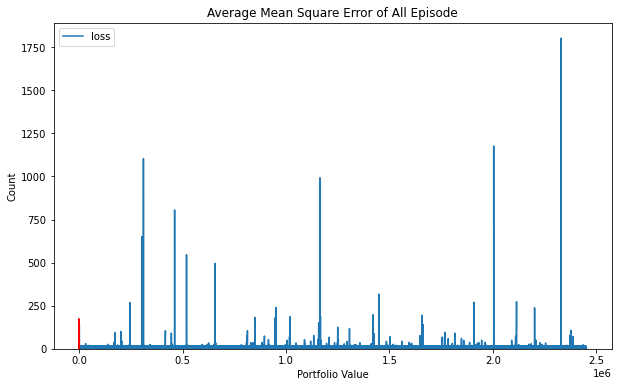

In [7]:
#train


mode = 'train'

cashflow = []



for e in tqdm(range(num_episodes)):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode, scaler)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {sum(val['cashflow']):.2f}, duration: {dt}")
    cashflow.append(sum(val['cashflow'])) 


if mode == 'train':
    # save the DQN
    agent.save(f'{stock_name}.npz')

    # save the scaler
    with open(f'{stock_name}.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
    loss = agent.model.losses
    losses = pd.DataFrame(loss, columns=['loss'])
    losses.plot(figsize=(10,6))
    plt.title('Average Mean Square Error of All Episode')
    plt.xlabel('Step')
    plt.ylabel('Mean Square Error')

print(f'average reward: {np.mean(cashflow):.2f}, min: {np.min(cashflow):.2f}, max: {np.max(cashflow):.2f}')
sns.histplot(cashflow, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

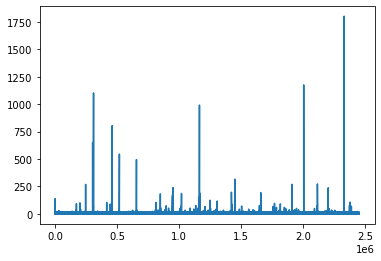

In [8]:
plt.plot(agent.model.losses)

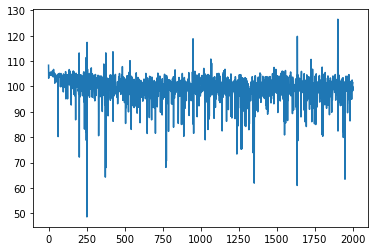

In [9]:
plt.plot(cashflow)

episode end value: 164.21, duration: 0:00:00.107552
Sell: 395 times, Buy: 352 times


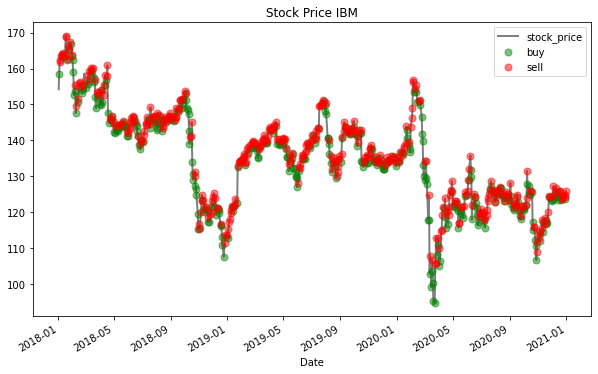

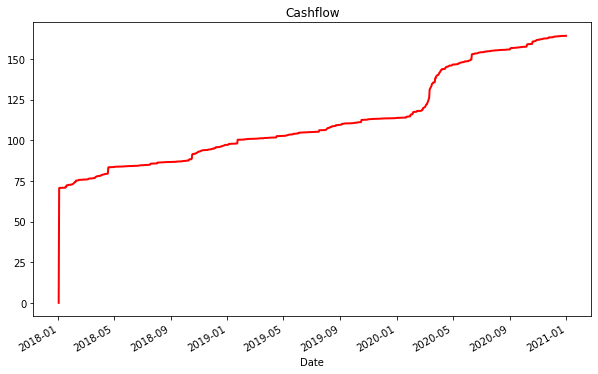

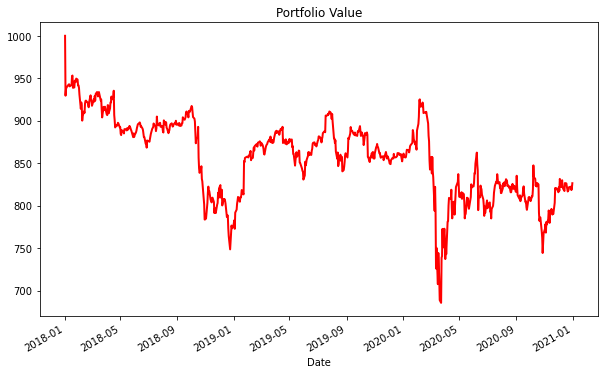

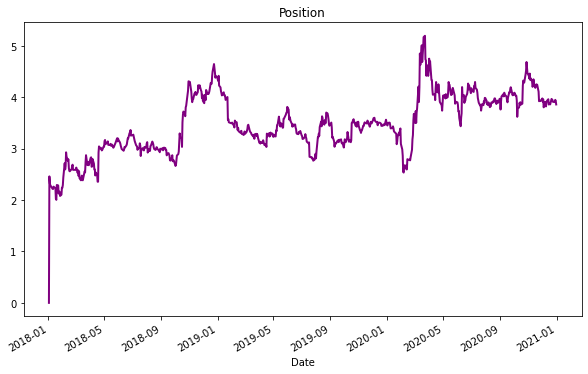

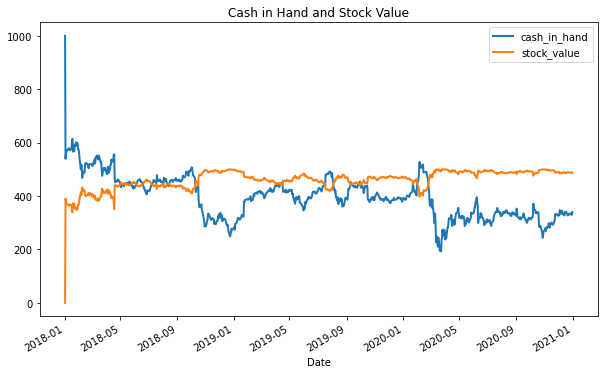

In [10]:
#test

mode = 'test'

cashflow = []


with open(f'{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
env = StockEnv(test_data, capital, high)
agent.epsilon = 0
agent.load(f'{stock_name}.npz')



t0 = datetime.now()
val = play_one_episode(agent, env, mode, scaler)
dt = datetime.now() - t0
print(f"episode end value: {sum(val['cashflow']):.2f}, duration: {dt}")
cashflow .append(sum(val['cashflow']))
    
print(f"Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")



result = pd.DataFrame(val)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['cashflow'].cumsum().plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()


result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


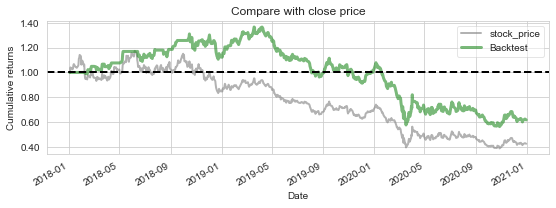

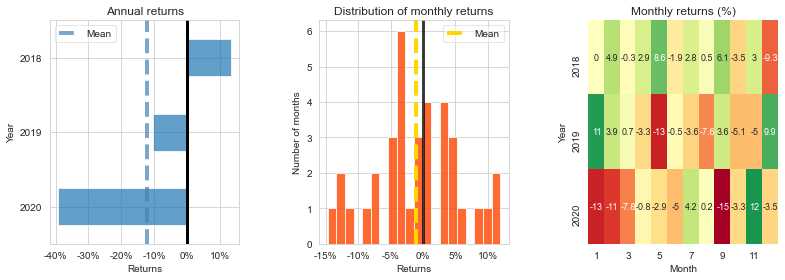

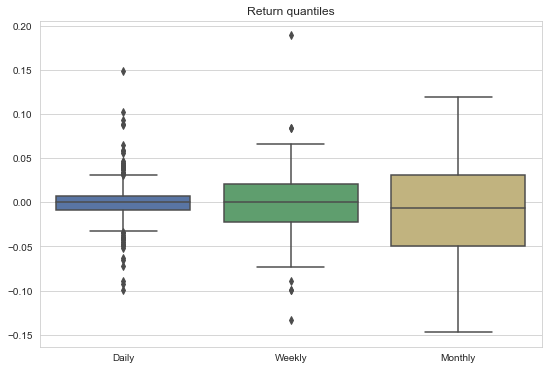

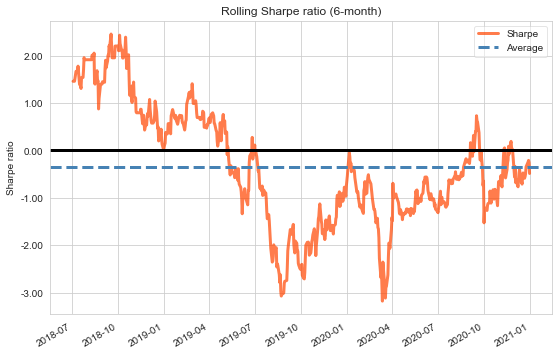

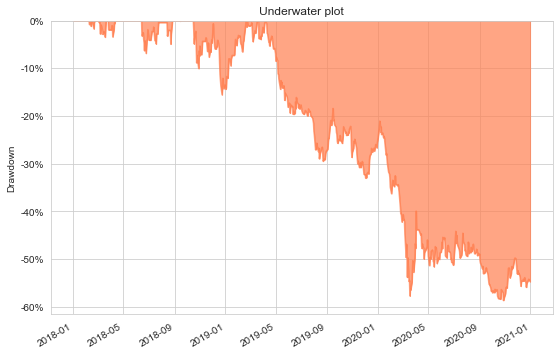

In [19]:
import pyfolio as pf
sns.set_style('whitegrid')

bt_returns = result['portfolio_value'].pct_change()
price = result['stock_price'].pct_change()



plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);